For developing and testing the SplitPropertiesScenario() object

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from janelia_core.ml.latent_regression.scenarios import SplitPropertiesScenario
from janelia_core.ml.latent_regression.scenarios import plot_single_2d_mode
from janelia_core.ml.latent_regression.vi import MultiSubjectVIFitter
from janelia_core.ml.latent_regression.vi import predict
from janelia_core.ml.utils import list_torch_devices
from janelia_core.ml.utils import torch_mod_to_fcn
from janelia_core.visualization.image_generation import generate_image_from_fcn


## Parameters go here

### Parameters for how we simulate ground truth data

In [3]:
n_neurons = [500, 500, 500] # Length gives number of subjects

bump_k = 10

bump_centers = [np.asarray([.25, .25]), 
                np.asarray([.75, .50])]

bump_stds = [np.asarray([.1, .5]), 
             np.asarray([.5, .1])]

coupling_std = 0.001

psi_noise_range = [.001, .002]

n_time_pts = 1000 # Number of time points to simulate for each subject



### Parameters for how we fit models

In [4]:
# Parameters for the prior
n_divisions_per_dim = 50
n_div_per_hc_side_per_dim = 3

## See what devices are available for computation

In [5]:
devices, cuda_is_available = list_torch_devices()

Found 1 GPUs


## Create scenario object

In [6]:
scenario = SplitPropertiesScenario(n_neurons=n_neurons,
                                   bump_k=bump_k,
                                   bump_centers=bump_centers,
                                   bump_stds=bump_stds,
                                   coupling_std=coupling_std,
                                   psi_noise_range=psi_noise_range)

## View bump functions in each property space

In [7]:
dim_sampling = np.asarray([[0, 1, .01], [0, 1, .01]])

In [8]:
n_prop_spaces = len(bump_centers)

def f_j(ind):
    return lambda x_j: scenario._bmp_fcn(x_j, ind)

bump_imgs = [generate_image_from_fcn(f_j(p_i), 
                                     dim_sampling=dim_sampling)[0]
             for p_i in range(n_prop_spaces)]

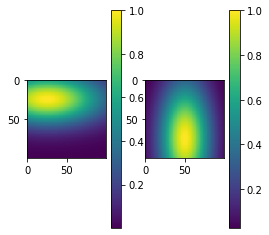

In [9]:
for p_i in range(n_prop_spaces):
    plt.subplot(1, n_prop_spaces+1, p_i+1)
    plt.imshow(bump_imgs[p_i])
    plt.colorbar()

## View couplings for neurons for one subject in different property spaces

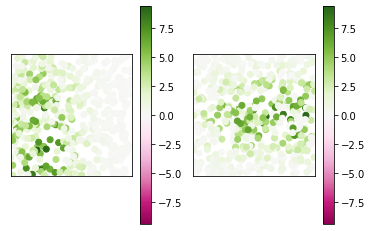

In [10]:
vis_subj = 0
couplings = scenario.subject_mdls[vis_subj].p[0].detach().numpy()
couplings = couplings.squeeze()

i0 = scenario.subject_mdls[vis_subj].neuron_prop_set_inds[0]
i1 = scenario.subject_mdls[vis_subj].neuron_prop_set_inds[1]
p0 = scenario.subject_mdls[vis_subj].neuron_props[:, i0].numpy()
p1 = scenario.subject_mdls[vis_subj].neuron_props[:, i1].numpy()

plt.figure()
ax = plt.subplot(1,2,1)
plot_single_2d_mode(couplings, p0, plot_axes=ax)
ax = plt.subplot(1,2,2)
plot_single_2d_mode(couplings, p1, plot_axes=ax)

## Generate data

In [11]:
with torch.no_grad():
    data = scenario.generate_data([n_time_pts]*3)

## Use variational inference to fit models to all subjects together

In [12]:
neuron_prop_set_inds = scenario.subject_mdls[0].neuron_prop_set_inds

In [13]:
p_priors, u_priors = scenario.generate_fitting_priors(
                                 set_inds=neuron_prop_set_inds,
                                 n_divisions_per_dim=n_divisions_per_dim,
                                 n_div_per_hc_side_per_dim=n_div_per_hc_side_per_dim)

In [14]:
subject_collections = [scenario.generate_training_collection(s_i=s_i, 
                                                             data=data_i)
                      for s_i, data_i in enumerate(data)]

In [15]:
vi_fitter = MultiSubjectVIFitter(p_priors=p_priors, 
                                 u_priors=u_priors, 
                                 s_collections=subject_collections)

In [19]:
vi_fitter.distribute(devices=devices)
logs=vi_fitter.fit(n_epochs=100, n_batches=10, update_int=10, 
                   learning_rates=.01, pin_memory=cuda_is_available)

*****************************************************
Epoch 0 complete.  Obj: 1.87e+04, LR: 0.01
Model NLLs:  s_0: 5.16e+03, s_1: 5.04e+03, s_2: 6.20e+03
Subj P KLs:  s_0: 7.72e+02, s_1: 8.11e+02, s_2: 7.44e+02
Subj U KLs:  s_0: 0.00e+00, s_1: 0.00e+00, s_2: 0.00e+00
Subj l2 W Penalties:  s_0: 0.00e+00, s_1: 0.00e+00, s_2: 0.00e+00
Device memory usage:  d_0: 2.53e+06
Device max memory usage:  d_0: 3.00e+06
Elapsed time: 2.83534574508667
*****************************************************
Epoch 10 complete.  Obj: 1.11e+04, LR: 0.01
Model NLLs:  s_0: 2.59e+03, s_1: 3.15e+03, s_2: 3.71e+03
Subj P KLs:  s_0: 5.53e+02, s_1: 5.94e+02, s_2: 5.41e+02
Subj U KLs:  s_0: 0.00e+00, s_1: 0.00e+00, s_2: 0.00e+00
Subj l2 W Penalties:  s_0: 0.00e+00, s_1: 0.00e+00, s_2: 0.00e+00
Device memory usage:  d_0: 2.52e+06
Device max memory usage:  d_0: 3.00e+06
Elapsed time: 29.57861876487732
*****************************************************
Epoch 20 complete.  Obj: 8.85e+03, LR: 0.01
Model NLLs:  s_0: 

In [20]:
vis_subj = 2

In [21]:
with torch.no_grad():
    y_pred = predict(subject_collections[vis_subj], data[vis_subj])
y_pred = y_pred[0]

subj_data = data[vis_subj][:]
y_true = subj_data.data[1][subj_data.i_y].numpy()

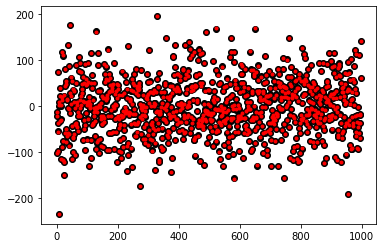

In [22]:
plt.plot(y_true, 'ko')
plt.plot(y_pred, 'r.')

In [36]:
plot_prop_grp = 1

In [37]:
p_priors[0] = p_priors[0].to('cpu')

In [38]:
scale = p_priors[0].dists[0].mn_f[2].s.detach().cpu().numpy()[0]

In [39]:
offset = p_priors[0].dists[0].mn_f[2].o.detach().cpu().numpy()[0]

In [40]:
mn_f = torch_mod_to_fcn(p_priors[0].dists[0].mn_f[0].group_modules[plot_prop_grp])

In [41]:
fit_img, _ = generate_image_from_fcn(mn_f, dim_sampling=dim_sampling)

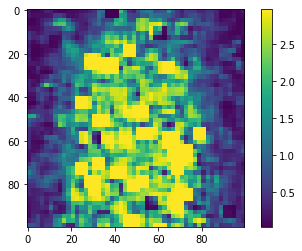

In [42]:
plt.imshow(scale*np.tanh(fit_img) + offset)
plt.colorbar()